# Concatenate data and creating subsets

### Step 04

**Out of personal experience**, the room `GL (Gang Leseecke)` might be the room where least changes in temperature due to sealings malfunction might occur (as there is no window to open). An installed controlled living room ventilation system running 365 days/year makes manual ventilation unnecessary and in practice windows are opened once a year for cleaning.
This room (and its window) is quite remote from the wind (predominantly blowing from the North-West) due to its location towards the East. Thats why the differences between this room and the most used and exposed to wind and outside temperatures part of the house  `VE (Vorzimmer Eingang)` - the front door of the building - is used for analytics.

Alternatives - as there are windows to open but quite far away from the sensor:
> `KO (Kinderzimmer Ost)` or \
> `KW (Kinderzimmer West)` or \
> `SZ (Schlafzimmer)`  

`GS (Gang Schrankraum)` might be too near to bathroom, where temperature levels may be strongly intertwined with usage.

In [6]:
import glob
import pandas as pd
import os

#global variable for a lot of or condensed output 
g_debug = 0

# Get data file names
path = r'C:/Users/andre/Nextcloud/WS_2023/IKT/20_Data'
all_files = glob.glob(os.path.join(path, "*.csv"))

if g_debug:
    print(all_files)

print(f'>>> Fetching data...')
# Concatenate all data into one DataFrame
all_data = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=False, axis=1)
print(f'...done')
print(all_data.tail())

print( f'\n>>> Converting types and creating new columns...')
# Convert all datetimes which are imported as object into datetime64(ns)
for c in all_data.columns:
    if (c == 'UTC'):
        all_data[c] = pd.to_datetime(all_data.iloc[:, 0])#format="%m/%d/%Y %H:%M") #[c]) #.iloc[:, 16]) #all_data['UTC'])

if g_debug:
    all_data.info()
    print(all_data.tail())

# make sure these columns are seen as numbers 
all_data['AU_DD'] = all_data['AU_DD'].astype(float)
all_data['AU_RF'] = all_data['AU_RF'].astype(float) #all_data['AU_RF'] = pd.to_numeric(all_data['AU_RF'], downcast='float')

#new columns
all_data['KO-VE'] = all_data['KO_Temp'] - all_data['VE_Temp']
all_data['KW-VE'] = all_data['KW_Temp'] - all_data['VE_Temp']
all_data['GS-VE'] = all_data['GS_Temp'] - all_data['VE_Temp']
all_data['GL-VE'] = all_data['GL_Temp'] - all_data['VE_Temp']
all_data['SZ-VE'] = all_data['SZ_Temp'] - all_data['VE_Temp']

print(f'...done')

# Show count, mean, standard deviation...

#percentile list
#perc = [.20, .40, .60, .80]
# list of dtypes to include
include = ['float'] #['object', 'float', 'int']
print(f'\n>>> Describe all data columns with type(s):'+str(include))
print(all_data.describe(include=include))  #dataframe.describe(percentiles, include, exclude, datetime_is_numeric)

>>> Fetching data...
...done
                        UTC    AG_Hell  AG_Hell_FLAG              UTC  \
359575  2023-09-16 16:20:00  22221.179           100  9/16/2023 16:20   
359576  2023-09-16 16:30:00  27178.325           100  9/16/2023 16:30   
359577  2023-09-16 16:40:00  26687.302           100  9/16/2023 16:40   
359578  2023-09-16 16:50:00  22083.129           100  9/16/2023 16:50   
359579  2023-09-16 17:00:00  22136.832           100  9/16/2023 17:00   

        AG_Temp  AG_Temp_FLAG                        UTC  AG_Wind  \
359575   26.259           500  2023-09-16 16:20:00+00:00  23.3244   
359576   26.500           100  2023-09-16 16:30:00+00:00  28.3284   
359577   26.500           500  2023-09-16 16:40:00+00:00  23.1120   
359578   26.500           500  2023-09-16 16:50:00+00:00  23.9400   
359579   26.403           100  2023-09-16 17:00:00+00:00  19.9160   

        AG_Wind_FLAG       AU_time  ...  VD_Temp_FLAG                  UTC  \
359575           100  1.694880e+18  ...

ValueError: Length of list vectors must match length of `data` when both are used, but `data` has length 359580 and the vector passed to `y` has length 1.

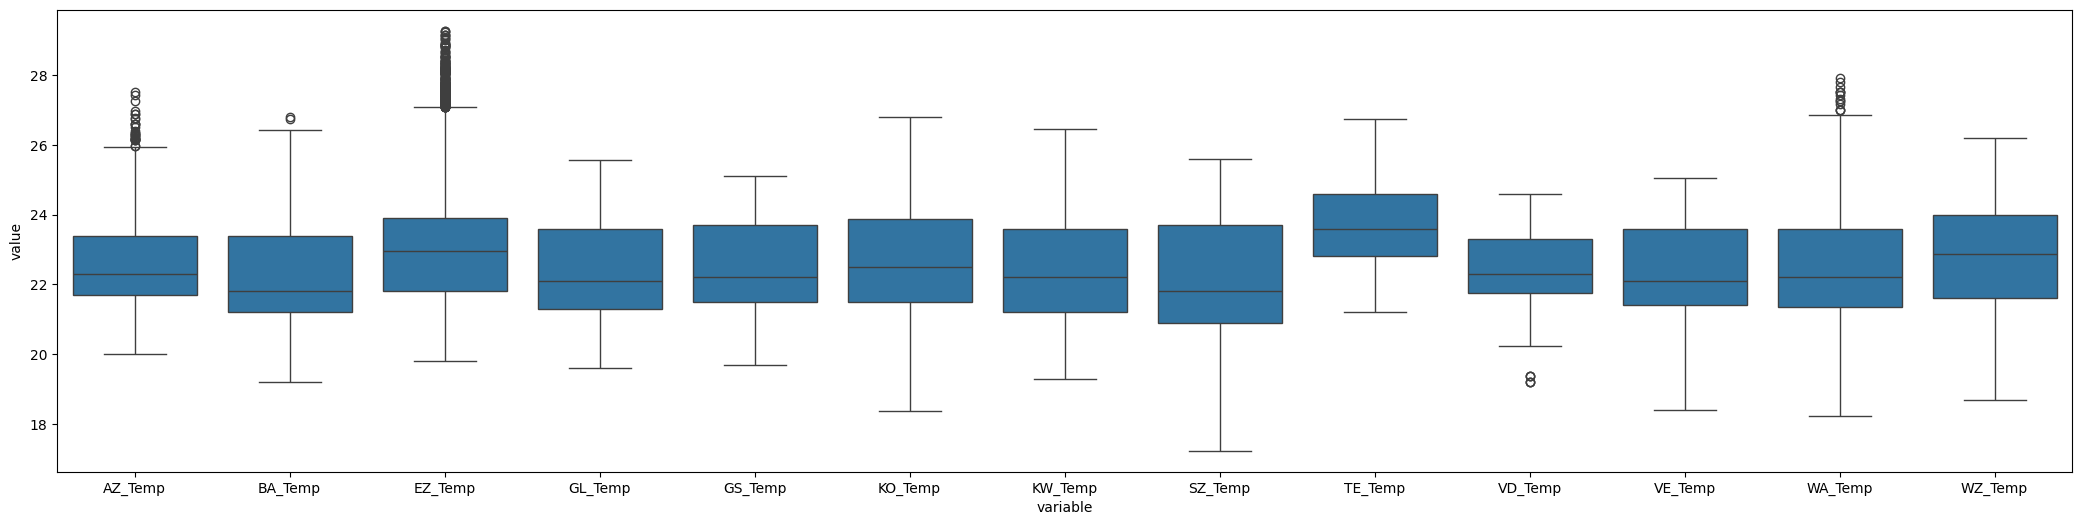

In [25]:
all_data_float = all_data.select_dtypes(include=[float])
all_data_float = all_data_float.filter(regex='Temp')
all_data_float = all_data_float.drop('AG_Temp', axis=1)
#all_data_float = all_data_float.drop('AG_Hell', axis=1) #axis=1 is used to specify to drop a column
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(26, 6))
#ax = sns.boxplot(x='attribute', y='temp', data=pd.melt(all_data))
ax = sns.boxplot(x='variable', y='value', data=pd.melt(all_data_float)) #(x=all_data.index, y=all_data.columns, data=all_data)
#ax = sns.boxplot(y='VE_Temp', data=all_data)

plt.show()

### Feature engineering/encoding

#### #01 - Finding Coldest months for subset 2
In order to find subsets of the total dataset with similar features, data shall be clustered/binned into categories. With time series analysis on expected and over the long run realized weather data, timestamps are a useful way of categorisation as seasonal patterns should emerge.  

The potential problem with sealings is found easier, if the temperature difference between indoor and outside is highest. This is accomplished by creating a category "month" and calculating the mean of outside temperature which helps filtering data for supporting our purpose. The three coldest months in the year were then chosen for this subset. In order to validate this categorisation also a clustering for coldest days was performed. An average daily outside temperature below 5°C (with few readings slightly above this value) was seen after day 326 and before day 67 (of the year), confirming that this timespan selection is useful.

In [21]:
t = range(all_data.index.size)
t #check if full dataset

##### augmented outside temperature
c = 18
#####
cn = all_data.iloc[:, c].name
# updating our dataFrame to have only one column as rest all columns are of no use for us at the moment 
# using .to_frame() to convert pandas series into dataframe.
all_data[cn] = pd.to_numeric(all_data[cn])
df_short = all_data[cn].to_frame()
#set date column as index
df_short = df_short.set_index(pd.DatetimeIndex(pd.to_datetime(all_data.iloc[:, 0])))
df_short.sort_index(inplace=True)
#df_short = df_short.asfreq(freq='10min')

df_short['mth'] = df_short.index.month.astype('category') #building a category on the index
 
print(df_short.dtypes)
print(df_short.groupby('mth', sort=False, observed=False).mean())

AU_TL     float64
mth      category
dtype: object
         AU_TL
mth           
11    6.264059
12    2.522248
1     1.352080
2     3.606060
3     6.694790
4    10.917057
5    15.198115
6    21.077391
7    22.007012
8    21.909604
9    16.769162
10   11.892156


#### #02 - Finding the windiest months
The same methodology used for finding the coldest months was applied to wind also. Hypothesis suggests that stronger wind puts more pressure to the front door increasing potential airleakages. 

Average wind speeds are highest between December and April in the used data set. But MoM (month on month) differences of average wind speed and wind direction do not change very much. Additionally this subset filtered on wind contains the coldest months, too. That's why further use of this potential subset was dismissed.

In [75]:
t = range(all_data.index.size)
t #check if full dataset
##### own outside temperature = 1; TL = 18; own outside wind = 4; FFAM (m/s) = 10; DD = 8
c = 10
#####
cn = all_data.iloc[:, c].name
# updating our dataFrame to have only one column as rest all columns are of no use for us at the moment 
# using .to_frame() to convert pandas series into dataframe.
all_data[cn] = pd.to_numeric(all_data[cn])
df_short = all_data[cn].to_frame()
#set date column as index
df_short = df_short.set_index(pd.DatetimeIndex(pd.to_datetime(all_data.iloc[:, 0])))
df_short.sort_index(inplace=True)
#df_short = df_short.asfreq(freq='10min')

df_short['mth'] = df_short.index.month.astype('category') #building a category on the index
#df_short['day'] = df_short.index.dayofyear.astype('category')
print(df_short.dtypes)

print(df_short.groupby('mth', sort=False, observed=False).mean())
#pd.set_option('display.max_rows', df_short.shape[0]+1)
#print(df_short.groupby('day', sort=False, observed=False).mean().head(365))

AU_FFAM     float64
mth        category
dtype: object
      AU_FFAM
mth          
11   3.288860
12   3.617662
1    3.637545
2    3.891036
3    3.657834
4    3.709110
5    3.128795
6    2.859071
7    2.734869
8    2.550928
9    2.610187
10   3.044351


#### #03 - Creating additional columns
Not a basic necessary step, but potentially useful for future in-depth analyses.

In [27]:
print( f'\n>>> Creating additional columns...')
all_data['AG-AU'] = all_data['AG_Temp'] - all_data['AU_TL']
all_data['AGW-AUF_inkmh'] = all_data['AG_Wind'] - all_data['AU_FFAM']*3.6

print(f'...done')


>>> Creating additional columns...
...done


#### Excursus: List of columns if necessary

In [43]:
# List of columns
#i = 0
#for col in all_data.columns:
#    print(str(i)+': '+col)
#    i += 1

all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359580 entries, 0 to 359579
Data columns (total 74 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   UTC            359580 non-null  datetime64[ns]
 1   AG_Temp        359580 non-null  float64       
 2   AG_Temp_FLAG   359580 non-null  int64         
 3   UTC            359580 non-null  datetime64[ns]
 4   AG_Wind        359580 non-null  float64       
 5   AG_Wind_FLAG   359580 non-null  int64         
 6   AU_time        359580 non-null  float64       
 7   AU_station     359580 non-null  int64         
 8   AU_DD          359580 non-null  float64       
 9   AU_DD_FLAG     359580 non-null  int64         
 10  AU_FFAM        359580 non-null  float64       
 11  AU_FFAM_FLAG   359580 non-null  int64         
 12  AU_FFX         359580 non-null  float64       
 13  AU_FFX_FLAG    359580 non-null  int64         
 14  AU_P           359580 non-null  float64       
 15  

#### #03 - Difference normalization
Observed temperature differences of specific locations in the house serve as an indicator for airtightness. To find a trend more easily (at a later stage), the mean of difference in the first year of observations shall serve as the "neutral level" to start from. Therefore we calculate this number and add/subtract it from every observation in the datapoint, creating a new column "..._n".

In [33]:
##### e.g. KO-VE
c = 66
period = 52596
#####
cn = all_data.iloc[:, c].name
# updating our dataFrame to have only one column as rest all columns are of no use for us at the moment 
# using .to_frame() to convert pandas series into dataframe.
all_data[cn] = pd.to_numeric(all_data[cn])
df_short = all_data[cn].to_frame()
m = df_short.head(period).mean()
print(m)
cnn = cn + '_n'
all_data[cnn] = all_data[cn].apply(lambda x: x - m)
print(f'>>> New column "'+cnn+'" added!')
print(all_data[cnn])

SZ-VE   -0.577446
dtype: float64
>>> New column "SZ-VE_n" added!
0        -1.022554
1        -1.022554
2        -1.022554
3        -1.022554
4        -1.022554
            ...   
359575    0.374446
359576    0.374446
359577    0.374446
359578    0.374446
359579    0.374446
Name: SZ-VE_n, Length: 359580, dtype: float64


### Creating subsets

In [42]:
from datetime import datetime

# Create subsets
print(f'>>> Creating subsets:')

##### Various Parameters
#wind direction in degrees, speed, temperature
wind_h = 320 #max, lower than...
wind_l = 220 #min, higher than...
windspeed_l = 0 #min, higher than in m/s
temp_h = 5 #max, lower than...
#taking out missing data 
time_l = datetime(2018, 12, 1, 2, 0) #'12/01/2018 02:00'
time_h = datetime(2018, 11, 18, 9, 0) #'11/18/2018 09:00'
#####

subset1 = all_data[(all_data['AU_DD'] >= wind_l) & (all_data['AU_DD'] <= wind_h) & (all_data['AU_FFAM'] >= windspeed_l) & (all_data['AU_TL'] <= temp_h) & ((all_data.iloc[:, 0] <= time_h) | (all_data.iloc[:, 0] >= time_l))]
print(f'Subset 1 created with ' +str(subset1.shape[0])+ ' rows')
 #all_data.query(
print(f'Describe Subset 1 data...')
print(subset1.describe(include=include))

#subset1a = all_data[(all_data['AG_Temp'] <= temp_h)]
#print(f'Subset 1a created with ' +str(subset1a.shape[0])+ ' rows')

##### Based on Datetime only
mth_start = 12
mth_end = 2
#####
#all_data = all_data.set_index(pd.DatetimeIndex(all_data['UTC']))
#s = all_data.index.month.astype('category') #building a category on the index
#s

subset2 = all_data[(all_data.iloc[:, 0].dt.month >= mth_start) | (all_data.iloc[:, 0].dt.month <= mth_end)]
#subset2 = all_data[(all_data.iloc[:, 0].index.month <= 2) & (all_data.iloc[:, 0].index.month >= 12)] 
print(f'Subset 2 created with ' +str(subset2.shape[0])+ ' rows')
print(f'Describe Subset 2 data...')
print(subset2.describe(include=include))


>>> Creating subsets...
Subset 1 created with 32884 rows
Subset 1a created with 101471 rows
Subset 2 created with 90864 rows
Describe Subset 2 data...
                       UTC       AG_Temp  AG_Temp_FLAG                  UTC  \
count                90864  90864.000000  90864.000000                90864   
mean   2020-01-15 11:55:00      2.139512    265.117098  2020-01-15 11:55:00   
min    2016-12-01 00:00:00    -15.100000    100.000000  2016-12-01 00:00:00   
25%    2018-02-06 17:57:30     -1.009000    100.000000  2018-02-06 17:57:30   
50%    2020-01-15 11:55:00      1.700000    100.000000  2020-01-15 11:55:00   
75%    2021-12-23 05:52:30      5.019750    500.000000  2021-12-23 05:52:30   
max    2023-02-28 23:50:00     24.984000    500.000000  2023-02-28 23:50:00   
std                    NaN      4.927963    196.935548                  NaN   

            AG_Wind  AG_Wind_FLAG       AU_time  AU_station         AU_DD  \
count  90864.000000  90864.000000  9.086400e+04     90864.0 

### Calculate correlation matrix

In [44]:
include = ['datetime', 'float', 'int']
all_data_sub = subset2.select_dtypes(include=include)  #subset1
print(all_data_sub)
all_data_sub.info()

# taking only special columns not to overload graph of correlation matrix
all_data_sub_f = subset2.select_dtypes(include='float64') #subset1
#all_data_sub_f = all_data.select_dtypes(include='float64')
all_data_sub_f.head()
all_data_sub_f.corr() #dataframe.corr(method, min_periods)


                       UTC  AG_Temp  AG_Temp_FLAG                 UTC  \
2357   2016-12-01 00:00:00    1.900           100 2016-12-01 00:00:00   
2358   2016-12-01 00:10:00    1.900           100 2016-12-01 00:10:00   
2359   2016-12-01 00:20:00    2.192           100 2016-12-01 00:20:00   
2360   2016-12-01 00:30:00    1.795           100 2016-12-01 00:30:00   
2361   2016-12-01 00:40:00    1.190           100 2016-12-01 00:40:00   
...                    ...      ...           ...                 ...   
330816 2023-02-28 23:10:00   -1.219           500 2023-02-28 23:10:00   
330817 2023-02-28 23:20:00   -1.219           500 2023-02-28 23:20:00   
330818 2023-02-28 23:30:00   -1.500           100 2023-02-28 23:30:00   
330819 2023-02-28 23:40:00   -1.500           500 2023-02-28 23:40:00   
330820 2023-02-28 23:50:00   -1.500           500 2023-02-28 23:50:00   

        AG_Wind  AG_Wind_FLAG       AU_time  AU_station  AU_DD  AU_DD_FLAG  \
2357     46.729           100  1.480550e+18  

,AG_Temp,AG_Wind,AU_time,AU_DD,AU_FFAM,AU_FFX,AU_P,AU_RF,AU_TL,AZ_Temp,...,GS-VE,GL-VE,SZ-VE,AG-AU,AGW-AUF_inkmh,KO-VE_n,KW-VE_n,GS-VE_n,GL-VE_n,SZ-VE_n
AG_Temp,1.000000,0.260694,0.192120,0.058057,0.245921,0.253473,-0.222403,-0.475227,0.934979,0.237347,...,-0.115728,0.161511,0.219214,0.339633,0.172835,0.356156,0.359344,-0.115728,0.161511,0.219214
AG_Wind,0.260694,1.000000,0.023643,0.361306,0.877910,0.874319,-0.084013,-0.468322,0.330277,0.046438,...,0.200647,0.243139,0.154991,-0.140921,0.752905,0.146591,0.121743,0.200647,0.243139,0.154991
AU_time,0.192120,0.023643,1.000000,0.035622,0.092591,0.038661,-0.059977,0.005522,0.201778,0.289138,...,-0.015262,0.153151,0.579819,0.006516,-0.080934,0.052308,0.166532,-0.015262,0.153151,0.579819
AU_DD,0.058057,0.361306,0.035622,1.000000,0.366690,0.328476,0.097191,-0.238903,0.094098,0.049817,...,0.222756,0.240480,0.167194,-0.085859,0.203999,0.065275,0.060473,0.222756,0.240480,0.167194
AU_FFAM,0.245921,0.877910,0.092591,0.366690,1.000000,0.973003,-0.099078,-0.476479,0.330623,0.075153,...,0.196418,0.254299,0.195283,-0.183480,0.345853,0.147267,0.124674,0.196418,0.254299,0.195283
AU_FFX,0.253473,0.874319,0.038661,0.328476,0.973003,1.000000,-0.119556,-0.481216,0.341986,0.045972,...,0.177665,0.223715,0.154441,-0.192323,0.375924,0.134532,0.108603,0.177665,0.223715,0.154441
AU_P,-0.222403,-0.084013,-0.059977,0.097191,-0.099078,-0.119556,1.000000,-0.006178,-0.269068,-0.105943,...,0.078723,0.041783,-0.049940,0.086549,-0.028450,0.084819,0.094844,0.078723,0.041783,-0.049940
AU_RF,-0.475227,-0.468322,0.005522,-0.238903,-0.476479,-0.481216,-0.006178,1.000000,-0.490819,-0.033967,...,-0.205731,-0.403057,-0.168215,-0.038122,-0.262802,-0.488897,-0.439049,-0.205731,-0.403057,-0.168215
AU_TL,0.934979,0.330277,0.201778,0.094098,0.330623,0.341986,-0.269068,-0.490819,1.000000,0.210149,...,-0.129706,0.135364,0.268907,-0.016069,0.192769,0.225979,0.229367,-0.129706,0.135364,0.268907
AZ_Temp,0.237347,0.046438,0.289138,0.049817,0.075153,0.045972,-0.105943,-0.033967,0.210149,1.000000,...,0.193377,0.202934,-0.030114,0.111808,-0.012296,0.197448,0.197315,0.193377,0.202934,-0.030114


### Visualize relevant correlations

- First we have a look at all the correlations (matrix)
- Second we analyse which correlations a certain column has with other columns (in a descending order)

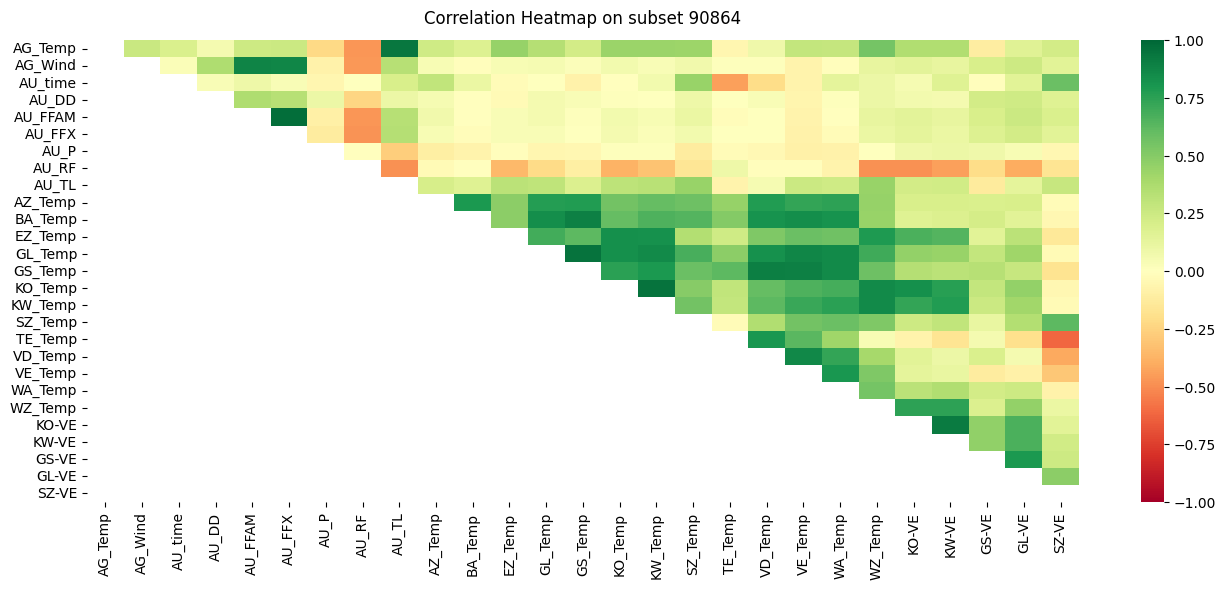

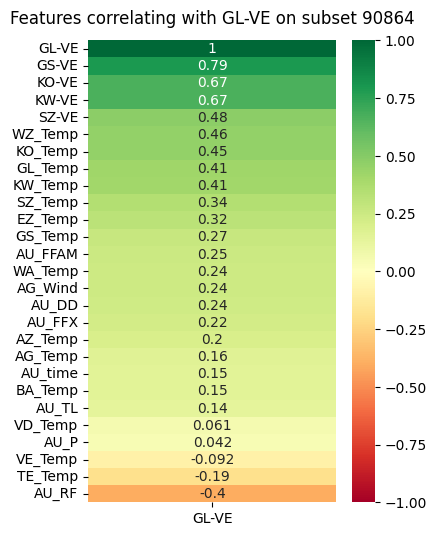

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import time
# create timestamp for export
date = time.strftime("%Y-%m-%d_%H%M%S")

# define the mask to set the values in the lower triangle to True (to hide it)
#mask = np.triu(np.ones_like(all_data_sub_f.corr()))
mask = np.tril(np.ones_like(all_data_sub_f.corr()))

# Increase the size of the heatmap
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(all_data_sub_f.corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap="RdYlGn") #center=0 cmap="PiYG"

if (len(all_data_sub_f.index) < 359580):
    heatmap.set_title('Correlation Heatmap on subset '+str(all_data_sub.shape[0]), fontdict={'fontsize':12}, pad=12);
    plt.savefig('heatmap_subset_'+str(all_data_sub.shape[0])+'_'+date+'.png', dpi=300, bbox_inches='tight')
else:
    heatmap.set_title('Correlation Heatmap on '+str(all_data_sub.shape[0]), fontdict={'fontsize':12}, pad=12);
    plt.savefig('heatmap_total_'+date+'.png', dpi=300, bbox_inches='tight')

##### define variable (column) on which to specifically look at
diff_col = 'GL-VE'
#####

plt.figure(2, figsize=(4, 6))
heatmap2 = sns.heatmap(all_data_sub_f.corr()[[diff_col]].sort_values(by=diff_col, ascending=False), vmin=-1, vmax=1, annot=True, cmap="RdYlGn") #center=0 cmap="PiYG"
if (len(all_data_sub_f.index) < 359580):
    heatmap2.set_title('Features correlating with '+diff_col+' on subset '+str(all_data_sub.shape[0]), fontdict={'fontsize':12}, pad=12);
else:
    heatmap2.set_title('Features correlating with '+diff_col+' on '+str(all_data_sub.shape[0]), fontdict={'fontsize':12}, pad=12);
plt.savefig('heatmap_'+diff_col+'_'+date+'.png', dpi=300, bbox_inches='tight')

### Save total DF or subsets of all data

In [45]:
if (len(all_data_sub.index) < 359580):
    filename = 'C:/Users/andre/Nextcloud/WS_2023/IKT/25_AllData/DF_subset_'+str(all_data_sub.shape[0])+'_at_'+date+'.csv'
    all_data_sub.to_csv(filename, sep=',', index=False, encoding='utf-8')
else:
    filename = 'C:/Users/andre/Nextcloud/WS_2023/IKT/25_AllData/DF_at_'+date+'.csv'
    all_data.to_csv(filename, sep=',', index=False, encoding='utf-8')
print(f'>>> Export to: \'' + filename + '\' successful')

>>> Export to: 'C:/Users/andre/Nextcloud/WS_2023/IKT/25_AllData/DF_subset_90864_at_2024-01-12_100051.csv' successful
